# Sentiment Analyse #

In diesem Notebook möchten wir die Usermeinung zum Spiel Cyperpunk 2077 analysieren. Wurde das Spiel von der Community wirklich so schlecht aufgenommen, wie es in anderen Medienportalen dargestellt wurde? Falls ja, wieso? Welche Kritikpunkte gab es? Was hätte der Publisher besser machen können? Um diese Fragen zu klären, klassifizieren wir die Kommentare zuerst mit VADER und anschließend mit dem Roberta-Modell, schauen uns die Resultate an und vergleichen die Ergebnisse des Wörterbuch-basierten Verfahrens mit den Ergebnissen des vortrainierten Transformer-Modells. Abschließend werden die Kritikpunkte in einer Topic-Analyse erörtert.

(**Anmerkung:** Wir bekommen ein Warning bei jeder Zelle, wegen eines Bugs in ipykernel (https://github.com/ipython/ipykernel/issues/540 ).
Zudem werden manche Plots, wegen Plotly, nicht richtig als Checkpoint abgespeichert. Bei diesen Plots haben wir zusätzlich einen Link auf ein Bild eingefügt, welches den Plot darstellt)
<hr>

In [1]:
%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# to print output only of last statement!
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [2]:
import sqlite3
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Matplotlib Backend
pd.options.plotting.backend = "matplotlib"

In [3]:
def pd_read_sql(database, sql, parse_dates=False):
    with sqlite3.connect(database) as con:
        dataframe = pd.read_sql_query(sql, con, parse_dates=['created_utc']) if parse_dates \
            else pd.read_sql_query(sql, con)
        return dataframe

def pd_write_sql(database, table, df):
    with sqlite3.connect(database) as con:
        df.to_sql(table, con, index=False, if_exists='replace')

Für die Sentiment Analyse benötigen wir nicht die in [Kapitel 1](./01_Textaufbereitung.ipynb) aufbereiteten Texte, sondern, um die Kommentare möglichst originalgetreu und ohne Verfälschungen klassifizieren zu können, verwenden wir die unaufbereiteten Kommentare der Spalte `body`.

In [4]:
sql = "SELECT id as comment_id, body FROM comments_prepared"
df = pd_read_sql("data.sqlite", sql)
df.sample(3)

comment_id  \
174891    gg6z5a3   
428324    g75r58d   
320566    geuydcs   

                                                                                                                                               body  
174891  Yeah its not that hard. The early game cars suck but thats expected. I swear most people who shit on this game played 4 hours and refunded.  
428324                                Hopefully they can just have a nice extended break after the game releases while everyone admires their work.  
320566                               How do you preload on Xbox? Can you only do it if you preorder the digital version? I ordered a physical disk.

## Sentiment Analyse: Vader ###

*VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.* (https://github.com/cjhutto/vaderSentiment)

Zuerst laden wir NLTK, das Vader als integriertes Paket enthält.

In [5]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\armin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Nun definieren wir uns eine Funktion, mit der wir stichprobenartig Kommentare auf ihr Sentiment testen.

In [6]:
def vader_sentiment_analyzer_scores(sentence):
    score = vader.polarity_scores(sentence)
    print(f"{sentence}  :  {score}")

In [7]:
text = df['body'].sample().iloc[0]
vader_sentiment_analyzer_scores(text)

*crashes  :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Wie man sieht, teilt Vader den Text einigermaßen gut für ein wörterbuchbasiertes Verfahren in `negativ`, `neutral` und `positiv` ein.

Im Folgenden verwenden wir nur den `compound`-Wert, der für jedes Wort im Satz den Score im Wörterbuch "nachschlägt", zusammenrechnet und am Ende einen normalisierten Wert zwischen -1 (extrem negativ) und +1 (extrem positiv) als Maß der Stimmung für den gesammten Satz ausgibt.

**Achtung**: Kann für die insgesamt knapp 442.000 Kommentare bis zu 4 Minuten brauchen. Das fertige Ergebnis wurde bereits in der Datenbank gespeichert und wird 4 Codeblöcke weiter aus der Datenbank gelesen und in einen DataFrame geladen.

In [8]:
df['sentiment_score'] = df['body'].progress_map(lambda x : vader.polarity_scores(x)["compound"])

  0%|          | 0/441494 [00:00<?, ?it/s]

Jetzt legen wir noch einen Schwellenwert für den oben generierten `compound-Wert` fest. Liegt der Wert über 0.05, so klassifizieren wir den Kommentar als `positiv`, falls er zwischen -0.05 und +0.05 liegt als `neutral` und sonst als `negativ`.

In [9]:
def map_senti(sentiment_score):
    if sentiment_score >= 0.05:
        return 'positive'
    elif -0.05 < sentiment_score < 0.05:
        return 'neutral'
    else:
        return 'negative'

In [10]:
df['sentiment_value'] = df['sentiment_score'].map(map_senti)

In [11]:
pd_write_sql("data.sqlite", "comments_sentiment_vader", df)

Geben wir den fertig klassifizierten Sentiment-DataFrame einmal aus, sehen wir, dass man mit Vader die Kommentare einigermaßen gut klassifizieren kann, manches aber auch oft nicht wirklich gut eingeordnet wurde.

In [12]:
df = pd_read_sql("data.sqlite", "SELECT * FROM comments_sentiment_vader")
df.sample(3)

comment_id  \
73828     giymjxa   
221876    gfghu5z   
279990    gfk46zz   

                                                                                                                         body  \
73828                                               Just press whatever button your system uses for weapon quick change twice   
221876                                                                                                             Same here.   
279990  Yeah there’s a set of cards in my apartment right by the door that are driving me nuts. I want to pick them up so bad   

        sentiment_score sentiment_value  
73828             -0.30        negative  
221876             0.00         neutral  
279990            -0.65        negative

In [13]:
df["sentiment_value"].value_counts().to_frame()

sentiment_value
positive           206197
negative           130661
neutral            104636

Von den knapp 442.000 Kommentaren wurden also durch `Vader` ca. 206.000 Kommentare als `positiv`, 130.000 als `negativ` und 104.000 als `neutral`eingestuft. Überraschend ist, dass doch so viele Kommentare als vermeintlich positiv eingestuft wurden, da das Spiel in anderen Medien bereits im Vorfeld stark kritisiert wurde.

<AxesSubplot:ylabel='Frequency'>

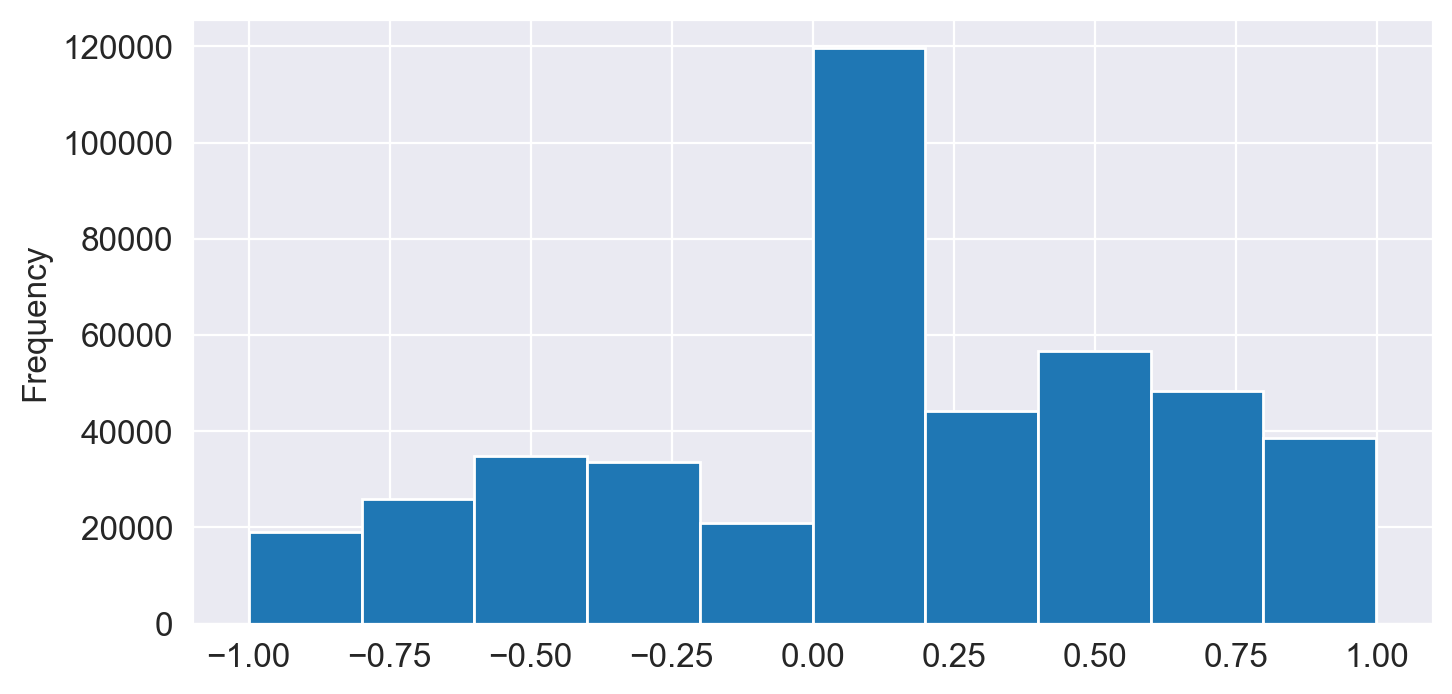

In [14]:
df["sentiment_score"].plot(kind="hist")

Lässt man sich die Verteilung grafisch ausgeben, sieht man das die meisten Kommentare als neutral eingestuft wurden und es mehr positive als negative Kommentare gibt.

## Sentiment Analyse mit Roberta ##

Wir führen als Nächstes eine Sentiment Analyse mithilfe von Roberta aus.
Bert, auf dass Roberta aufbaut, ist ein Modell für die Verarbeitung natürlicher Sprache, das von Forschern bei Google Research im Jahr 2018 präsentiert wurde.
([Quelle](https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/)).

 Roberta modifiziert wichtige Hyperparameter, indem es das Ziel des Vortrainings des nächsten Satzes entfernt
 und mit viel größeren Mini-Batches und Lernraten trainiert ([Quelle](https://huggingface.co/transformers/model_doc/roberta.html)).

Das Roberta Modell, welches im Folgenden verwendet wird, wurde auf ~58 Mio. Tweets trainiert und für die Sentiment-Analyse mit
dem TweetEval-Benchmark feinjustiert ([Quelle](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)).


Nun werden die unbereinigten Kommentare der body-Spalte und das jeweils dazugehörige Datum des Beitrags, zu dem der Kommentar gehört,
geladen.

In [15]:
sql = "SELECT c.id as comment_id, body, s.created_utc From comments_prepared c join submissions s on s.id = c.submission_id"
df = pd_read_sql("data.sqlite", sql)

Wir definieren uns eine Funktion, die den classifier, welcher auf dem twitter-roberta-base-sentiment beruht, auf die
175 ersten Buchstaben des übergebenen Kommentars anwendet und je nach Ergebnis den passenden Sentiment-Value und
Sentiment-Score zurückliefert. (Auf BERT-basierte Modelle haben eine maximale Sequence-Länge, weshalb ab einer bestimmten Länge Exceptions auftreten können. Daher begrenzen wir die Textlänge auf 175 Buchstaben, die sich bei uns als Optimalwert herausgestellt hatte.)

**Achtung:** Der Prozess wird auf einer GPU (RTX 3080) ausgeführt und dauert damit ca. 1,5h. Beim erneuten Ablauf wurde das ganze ausversehen abgebrochen, deswegen steht dort KeyboardInterrupt. Der Code funktioniert aber und die Ergebnisse sind trotzdem vorhanden (Um das Ergebnis zu sehen, bitte zur nächsten Zelle springen)

In [39]:
from transformers import pipeline
from tqdm.auto import tqdm
import torch

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
classifier = pipeline("sentiment-analysis", model=MODEL, device=0)
tqdm.pandas()

#Check output if the pipeline runs on the gpu
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

def classification(text: str):
    classifier_result = classifier([text[:175]])[0]
    if classifier_result["label"] == "LABEL_0":
        classifier_result["label"] = "negative"
    elif classifier_result["label"] == "LABEL_1":
        classifier_result["label"] =  "neutral"
    else:
        classifier_result["label"] = "positive"
    return classifier_result["label"], classifier_result["score"]

df["sentiment_value"], df["sentiment_score"] = zip(*df["body"].progress_apply(classification))
pd_write_sql("data.sqlite", "comments_sentiment_roberta", df)

True
0
1
NVIDIA GeForce RTX 3080


  0%|          | 0/435689 [00:00<?, ?it/s]

KeyboardInterrupt: 

Anzeigen der gelabelten Dateien:

In [16]:
df = pd_read_sql("data.sqlite", "SELECT * From comments_sentiment_roberta", True)
df.sample(5)

comment_id  \
246803    gfyje6o   
40678     gkc4jvb   
139751    gg8nqvv   
220550    gfh5rxp   
198152    gfhb9nb   

                                                                                                                                                                                                           body  \
246803  > imagine if they announced before launch its delayed again for a year\n\nHow about you don't announce a launch before you are 95% done? It really is that simple and worked historically pretty wel...   
40678                 Not going to pre order regardless. All the good Devs left when Witcher 3 was finished it seems, Cyberpunk is actually kind of a garbage game. All the crunch just drives away the talent.   
139751                                                                                                                                                  You know, since CDPR is the new Bethesda or Square Enix   
220550                                                                                                                                                                           pause menu, bottom left corner   
198152                                                                                      Maybe that’s the reason everyone’s saying it’s blurry on the last gen consoles, they just haven’t progressed enough   

       created_utc sentiment_value  sentiment_score  
246803  2020-12-15         neutral             0.61  
40678   2021-01-23        negative             0.86  
139751  2020-12-18         neutral             0.91  
220550  2020-12-11         neutral             0.80  
198152  2020-12-10        negative             0.63

### Sentiment Analyse Plotten ###

Wir möchten uns jetzt die gelabelten Daten über den Zeitverlauf grafisch ausgeben lassen.

Wir definieren uns eine Funktion, die je nach Label einen passenden one-hot-vector baut. Mithilfe dessen kann der
Plot geplottet werden.

In [17]:
#Plotly Backend
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

In [18]:
def count_keywords(tokens):
    if tokens == "negative":
        return [1,0,0]
    elif tokens == "positive":
        return [0,1,0]
    else:
        return [0,0,1]

def sentiment_plot(df):
    df['Year/Month'] = df['created_utc'].dt.strftime("%Y/%m")
    by='Year/Month'
    freq_matrix = df['sentiment_value'].progress_apply(count_keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=["negative", "positive", "neutral"])
    freq_df[by] = df[by]
    sentiment_plot_df = freq_df.groupby(by=by).sum().sort_values(by)
    return sentiment_plot_df.plot(kind='line', line_shape='spline')

Aufruf der Funktion [Bild](./img/sentiment_plot.png):

In [19]:
sentiment_plot(df)

  0%|          | 0/435689 [00:00<?, ?it/s]

Wir erkennen, dass die negativen Kommentare zu jeder Zeit überwiegen. Das kann man darauf zurückführen, dass Menschen sich eher über Sachen beschweren, anstatt etwas zu loben.

Interessant hierbei sind aber eher die verschiedenen Kurvenverläufe:
 * Die positiven Kommentare nehmen bis zum Dezember, also bis zum Release stetig zu. Im Dezember erreichen sie ihren Peak und nehmen dann stetig ab.
 * Die neutralen Kommentare verhalten sich ähnlich zu den positiven Kommentaren.
 * Die negativen Kommentare hingegen haben einen Peak im Oktober und einen weiteren Peak im Dezember. Diese Peaks stimmen mit den Peaks der negativen Begriffe überein, die wir auch schon in der Explorativen Datenanalyse entdeckt haben.
 (Im Oktober: "crunch", "overtime", "delay". Im Dezember "bug", "issue", "refund", "patch")
 ![title](./img/heatmap.png)

<hr>

Da jeder sentiment_value einen passenden sentiment_score bekommt, wollen wir das Ganze anhand dieses sentiment_score
filtern, damit wir sehen können, wie aussagekräftig der Plot ist [Bild](./img/sentiment_plot_2.png).

In [20]:
df = pd_read_sql("data.sqlite", "SELECT * From comments_sentiment_roberta Where sentiment_score >= 0.75", True)
sentiment_plot(df)

  0%|          | 0/180965 [00:00<?, ?it/s]

Wir sehen, dass die neutralen Kommentare um einiges abgenommen haben und die meiste Zeit unter dem Graph der negativen
Kommentare liegen. Beim vorherigen Graph war das andersherum.

Da sich unsere Analyse aber nur auf die Graphenverläufe bezieht und diese gleich geblieben sind, können wir festhalten,
dass unsere Analyse eine gute Aussagekraft hat.

## Roberta im Vergleich mit Vader ##

Um beide Sentimentanalysen gegenüberzustellen, laden wir diese zunächst in jeweils einen DataFrame.

In [21]:
df_roberta = pd_read_sql("data.sqlite", "SELECT * FROM comments_sentiment_roberta")
df_roberta.sample(3)

comment_id  \
32983     gkl7671   
132928    gg8dnk6   
70237     gj8wukg   

                                                                                                                                                                                                 body  \
32983                                                                                                                                     Doesn't work for me.  No sidequests to do with that option.   
132928                                   I highly doubt that, all the kids are gonna be asking for Cyberpunk this Christmas, including me... I'll probably wait a few months before I play it though.   
70237   The game is not finished. How can any reviewer recommend it at? It’s like watching a half filmed movie and giving it a perfect score. \n\nThe game should be reviewed in when it is finished.   

       created_utc sentiment_value  sentiment_score  
32983   2021-01-22        negative             0.92  
132928  2020-12-18         neutral             0.46  
70237   2021-01-13        negative             0.68

In [22]:
df_vader = pd_read_sql("data.sqlite", "SELECT * FROM comments_sentiment_vader")
df_vader.sample(3)

comment_id  \
316118    gez6o4b   
93044     ght7bl7   
408892    g93q1zj   

                                                                                                                                                                                                           body  \
316118                                                      Relax buddy, it's gotten a 93 rating, if it keeps up it's looking like the best release this year, ahead of GoT and TLOU2 which isn't a small feat.   
93044   Explain how the city is an accomplishment in any capacity.\n\nBecause looking at it through the lens of a 3080, it looks fucking mediocre. Not even considering the dogshit AI , rampant bugs and gl...   
408892                                                                                                                                                                        Might be a better experience haha   

        sentiment_score sentiment_value  
316118             0.86        positive  
93044             -0.48        negative  
408892             0.71        positive

Um die Anzahl der von Vader in `negativ`, `neutral` und `positiv`aufgeteilten Kommentare nun mit denen von Roberta vergleichen zu können, laden wir die klassifizierten Kommentare von beiden in einen neuen DataFrame und vergleichen diese jeweils paarweise.

In [23]:
combined_df = pd.merge(df_roberta, df_vader, left_on='comment_id', right_on='comment_id', how='left', suffixes=('_roberta', '_vader'))

In [24]:
combined_df.sample(3)

comment_id  \
300882    gf2n007   
91296     gi4xql8   
146826    gg8sowm   

                                                                                                                            body_roberta  \
300882                                                 How about holding game developers to actually put out a finished product for once   
91296                                                                            That’s very interesting—let us know if you can confirm.   
146826  That screws over, what , like 50 people tops? No one is gonna have much sympathy for rich actors;directors who can’t get richer.   

       created_utc sentiment_value_roberta  sentiment_score_roberta  \
300882  2020-12-08                 neutral                     0.74   
91296   2021-01-04                positive                     0.92   
146826  2020-12-18                negative                     0.69   

                                                                                                                              body_vader  \
300882                                                 How about holding game developers to actually put out a finished product for once   
91296                                                                            That’s very interesting—let us know if you can confirm.   
146826  That screws over, what , like 50 people tops? No one is gonna have much sympathy for rich actors;directors who can’t get richer.   

        sentiment_score_vader sentiment_value_vader  
300882                   0.00               neutral  
91296                    0.00               neutral  
146826                   0.90              positive

Schaut man sich beispielhaft die Kommentare und deren Sentiment an, wird deutlich, dass die durch Roberta klassifizierten Kommentare besser dem jeweiligen Sentiment zugeordnet werden konnten.

Nun möchten wir wissen, wie sich die Kommentare insgesamt für Vader als auch Roberta auf die 3 Kategorien aufteilen und vergleichen diese miteinander.

In [25]:
df_vader = combined_df["sentiment_value_vader"].value_counts().to_frame()
df_roberta = combined_df["sentiment_value_roberta"].value_counts().to_frame()

result_df = pd.concat([value.reset_index(drop=True) for value in [df_roberta.sort_index(), df_vader.sort_index()]], axis=1)
result_df = result_df.rename(index={0: "negative", 1: "neutral", 2: "positive"})
result_df

sentiment_value_roberta  sentiment_value_vader
negative                   166159                 128644
neutral                    184664                 103417
positive                    84866                 203628

Man sieht also sehr deutlich, dass Roberta weitaus mehr Kommentare als `negativ` einordnet, als es Vader tut. Kombiniert man nun die Ergebnisse der in [Kapitel 1](./02_Explorative_Datenanalyse.ipynb) erstellten WordClouds und das Ergebniss der folgenden Topic-Analyse mit dem Verhältnis der negativ zu positiv Kommentaren (166.000 negative Kommentare zu 85.000 positiven), ist das Ergebnis des Roberta-Modells sehr plausibel. Deshalb wird in den folgenden Abschnitten mit den von Roberta klassifizierten Kommentaren weitergearbeitet.

## Roberta N-Gramme ##

Um herauszufinden, warum es so viele negative Kommentare gibt und auf was sich diese beziehen, erstellen wir für die weiteren Analysen einen DataFrame, der gezielt die negativ klassifizierten Kommentare enthält.

In [26]:
sql = "SELECT * From comments_prepared c JOIN comments_sentiment_roberta s ON c.id = s.comment_id " \
      "Where sentiment_value = 'negative'"
df_only_negative = pd_read_sql("data.sqlite", sql)

Nun werden drei Funktionen definiert, die die ersten n `Uni`, `Bi`- und `Trigramme` für den negativen Korpus ausgeben. Dafür wird die `CountVectorizer` Funktion von [scikit-learn](https://scikit-learn.org/stable/) verwendet.

In [27]:
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Aufruf Unigram [Bild](./img/unigram.png):

<AxesSubplot:title={'center':'Top 20 unigrams in negative classified comments'}, xlabel='Lemmas'>

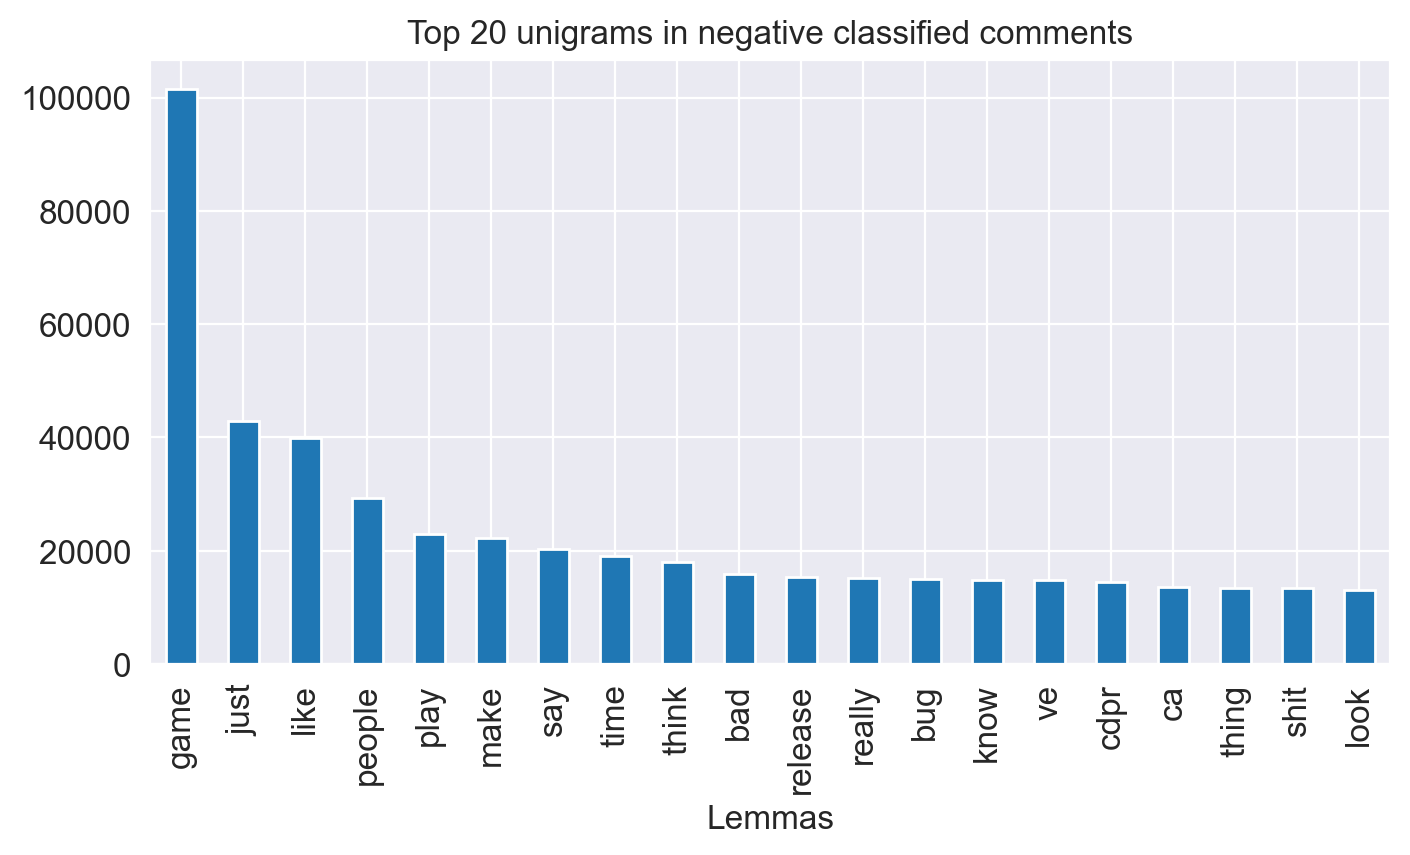

In [44]:
#Matplotlib Backend
pd.options.plotting.backend = "matplotlib"

common_words = get_top_n_unigram(df_only_negative['lemmas'], 20)
top_20_unigram_df = pd.DataFrame(common_words, columns = ['Lemmas' , 'count'])
top_20_unigram_df.groupby('Lemmas').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 unigrams in negative classified comments')

Bereits bei den Unigrammen stechen Begriffe wie `bad`, `release` und `bug` heraus. Um diese Begriffe in einem besseren Kontext einordnen zu können, werden nun die Bigramme grafisch dargestellt [Bild](./img/bigram.png).

<AxesSubplot:title={'center':'Top 20 bigrams in negative classified comments'}, xlabel='Lemmas'>

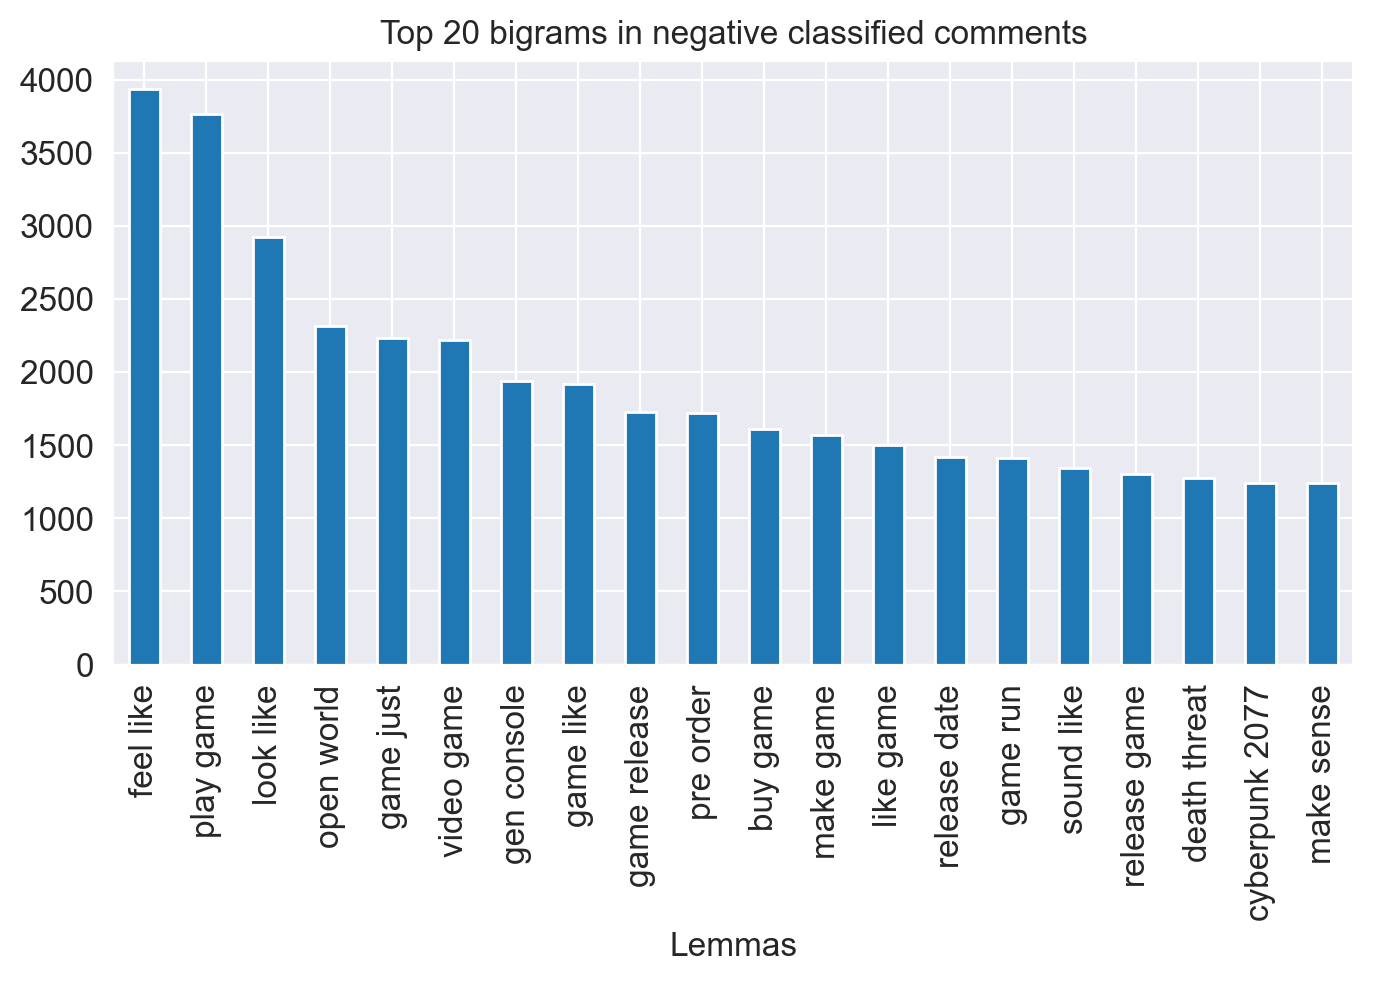

In [45]:
common_words = get_top_n_bigram(df_only_negative['lemmas'], 20)
top_20_bigram_df = pd.DataFrame(common_words, columns = ['Lemmas' , 'count'])
top_20_bigram_df.groupby('Lemmas').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams in negative classified comments')

Nochmal deutlicher auftretend sind hier Begriffe wie `gen console`, `pre order` und `release date`.

Aufruf Trigram [Bild](./img/trigram.png):

<AxesSubplot:title={'center':'Top 20 trigrams in negative classified comments'}, xlabel='Lemmas'>

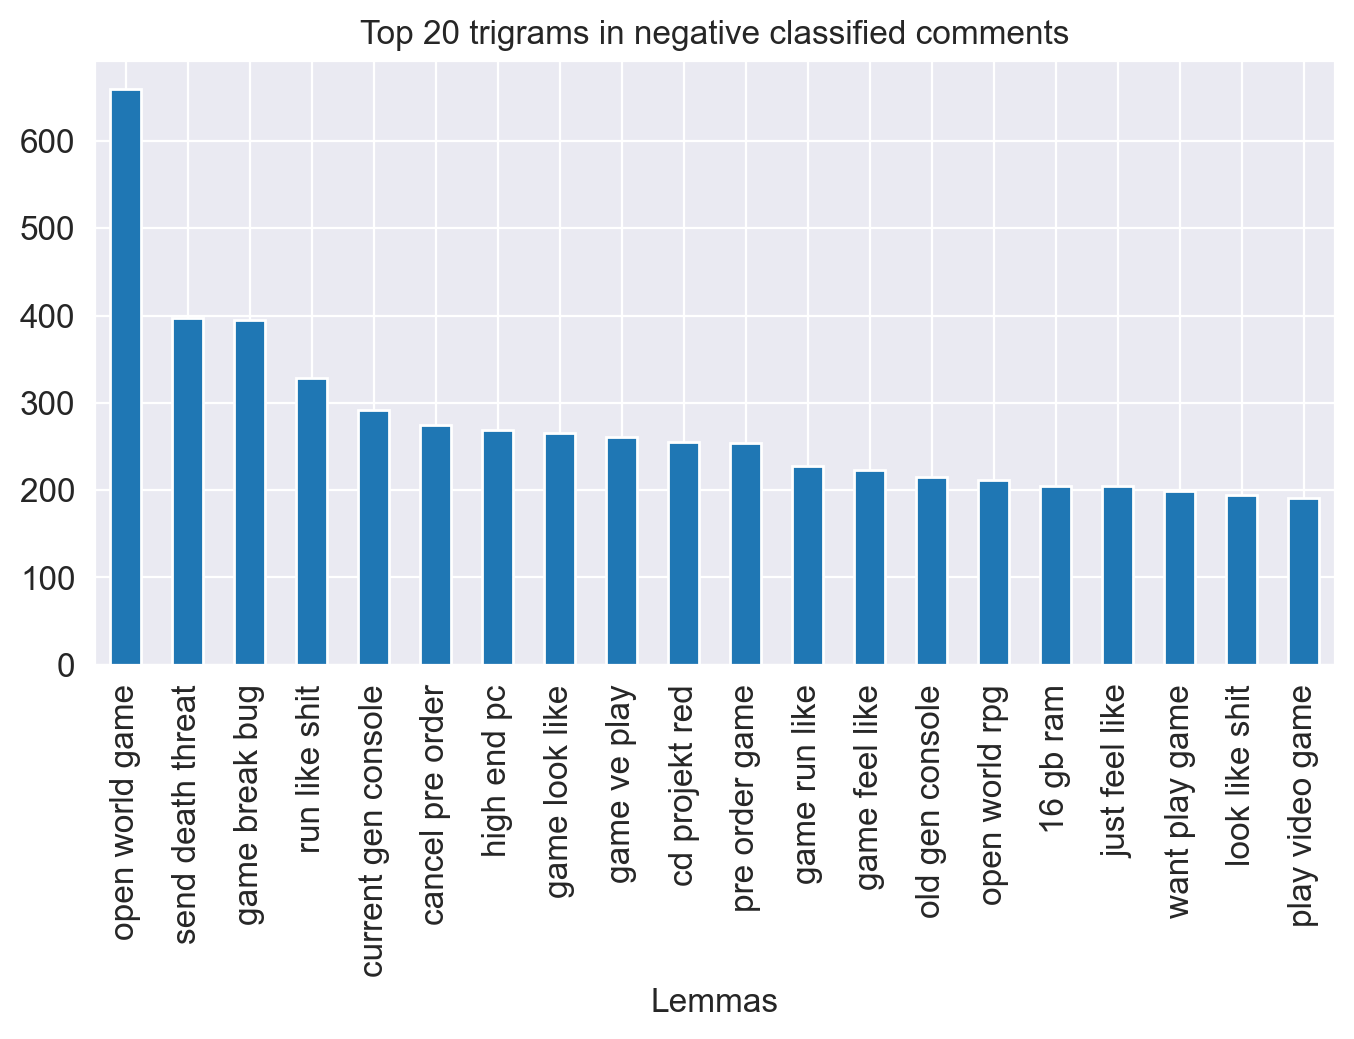

In [46]:
common_words = get_top_n_trigram(df_only_negative['lemmas'], 20)
top_20_trigram_df = pd.DataFrame(common_words, columns = ['Lemmas' , 'count'])
top_20_trigram_df.groupby('Lemmas').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams in negative classified comments')



Letztlich erkennt man deutlich, dass sich der Großteil der negativen Kommentare auf In-Game Probleme wie Bugs und die miserable Performance auf der aktuellen Konsolengeneration bezieht. Aber auch Probleme wie die wiederholte Verzögerung des geplanten Erscheinungsdatums, welche zur einer Welle von Stornierungen der Vorbestellungen führte, wird häufig in einem negativen Kontext erwähnt.

## Roberta Topic Analyse ##
Um die Themen herauszufinden, um die sich die negativen Kommentare drehen, werden wir als Nächstes eine Topic-Analyse
durchführen. Wir laden dafür zuerst die Nouns aus den Kommentaren, die negativ bewertet worden sind.
Außerdem soll der Kommentar einen Sentiment-Score größer gleich 75% haben, damit wollen wir erreichen, dass sich unser
Klassifikator zu einer hohen Wahrscheinlichkeit sicher ist, den Kommentar richtig eingeordnet zu haben.

In [33]:
sql = "SELECT nouns, lemmas From comments_prepared c JOIN comments_sentiment_roberta s ON c.id = s.comment_id " \
      "Where sentiment_value = 'negative' AND sentiment_score >= 0.75"
df = pd_read_sql("data.sqlite", sql)

Wir setzen die Text-Spalte, auf die wir uns beziehen, auf Nouns fest. Wir legen zudem eine Liste von StopWords fest, welche rausgefiltert werden sollen. Dann lassen wir unsere Topic-Analyse laufen. Wir probieren dafür mehrere Werte für die Parameter aus:
 * Gramme: Unigram, Bigram, Trigram
 * Anzahl Topics: 4, 8
 * Anzahl Iterationen: 5, 10
 
(Anmerkung: durch erneutes Durchlaufen haben sich die Ergebnisse hier und in der nächsten Zeile leider verändert. Deswegen weicht unser Analyse Text von der Ausgabe ab)

In [34]:
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

text_col = 'nouns'
stop_nouns = """
game people time thing year day way hour lot point shit setting car money guy month lol mission company video
cyberpunk witcher stuff man reason life post person example work date fuck option comment
""".strip().split()
for i in tqdm([1, 2, 3]):
   count_vect = CountVectorizer(ngram_range=(1, i),
                                min_df=3,
                                max_df=1.0,
                                lowercase=False,
                                stop_words=stop_nouns)

   X_tf = count_vect.fit_transform(df[text_col])

   type(X_tf)
   X_tf.shape

   for num_topics in tqdm([4, 8]):
       for iteration in tqdm([5, 10]):
           lda2 = LatentDirichletAllocation(n_components=num_topics,  max_iter=iteration)
           lda2.fit(X_tf)

           lda_display = pyLDAvis.sklearn.prepare(lda2, X_tf, count_vect, sort_topics=False)
           pyLDAvis.display(lda_display)

C:\Users\armin\anaconda3\envs\textanalytics_project\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/3 [00:00<?, ?it/s]

scipy.sparse.csr.csr_matrix

(85074, 8859)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=4)

LatentDirichletAllocation(n_components=4)

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=8)

LatentDirichletAllocation(n_components=8)

scipy.sparse.csr.csr_matrix

(85074, 28148)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=4)

LatentDirichletAllocation(n_components=4)

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=8)

LatentDirichletAllocation(n_components=8)

scipy.sparse.csr.csr_matrix

(85074, 30384)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=4)

LatentDirichletAllocation(n_components=4)

  0%|          | 0/2 [00:00<?, ?it/s]

LatentDirichletAllocation(max_iter=5, n_components=8)

LatentDirichletAllocation(n_components=8)

Das beste Ergebnis bekommen wir aus der Kombination von Unigram, Bigram und Trigram, Anzahl Topics: 4 und Anzahl
Iterationen: 10.

Die Themen sind gut verteilt und aus den zugeordneten Wörtern zu den Topics kann man gut etwas herauslesen.

Wir wollen der übersichthalber dieses Ergebnis nochmal alleine plotten [Bild](./img/topic_analyse.png).

In [35]:
count_vect = CountVectorizer(ngram_range=(1, 3),
                                 min_df=3,
                                 max_df=1.0,
                                 lowercase=False,
                                 stop_words=stop_nouns)

X_tf = count_vect.fit_transform(df[text_col])

type(X_tf)
X_tf.shape
lda2 = LatentDirichletAllocation(n_components=4,  max_iter=10)
lda2.fit(X_tf)

lda_display = pyLDAvis.sklearn.prepare(lda2, X_tf, count_vect, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\armin\anaconda3\envs\textanalytics_project\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Analyse der verschiedenen Themen:
 * Thema 1: Hier werden viele Wörter in Zusammenhang mit dem Entwickler erwähnt, die sich wohl auf den Release beziehen. Selbiges Thema hatten wir bereits in der explorativen Analyse gefunden und näher erläutert.
 * Thema 2: Dieses Thema ist sehr allgemein. Es wird erwähnt, dass es Probleme gibt, ohne darauf näher einzugehen.
 * Thema 3: In diesem Thema geht es um die verschiedenen Versionen des Spiels. Dabei steht neben der Pc Version auch die Playstation Version mit mehreren Worten im Vordergrund ("Sony", "PS4", "ps4"). Das liegt wahrscheinlich daran, dass diese Version sehr viele Probleme hatte und im Zuge dessen auch aus dem Playstation Store entfernt wurde und eine Rückerstattung angeboten wurde
 [Quelle](https://www.gameswirtschaft.de/marketing-pr/sony-entfernt-cyberpunk-2077-playstation-store-211220/).
 Passend dazu gibt es auch Worte in diesem Thema ("refund", "store")
 * Thema 4: Hier werden viele Sachen erwähnt, welche das Gameplay des Spiels betreffen. Diese möchten wir im Folgenden näher untersuchen.
 
<hr>
 
Wir möchten als Nächstes die Trigrame zu einigen der Wörter plotten, die im Thema 4 genannt werden. Dazu definieren wir uns eine Funktion, die das DataFrame auf die Lemmas einschränkt, welche die gesuchten Wörter beeinhalten und dann darauf basierend die 20 meist vorkommenden Trigramme plottet. Daraus erhalten wir dann einen etwas genaueren Kontext.

In [34]:
pd.options.plotting.backend = "matplotlib"
def trigram_call(text):
    testdf = df
    df_filtered = testdf[testdf["lemmas"].str.contains(pat = f' {text} ')]
    common_words = get_top_n_trigram(df_filtered['lemmas'], 20)
    top_20_trigram_df = pd.DataFrame(common_words, columns = ['Lemmas' , 'count'])
    top_20_trigram_df.groupby('Lemmas').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 trigrams in negative classified comments')

Wir rufen unsere Funktion nacheinander mit den Worten "character", "world" und "ai" auf:

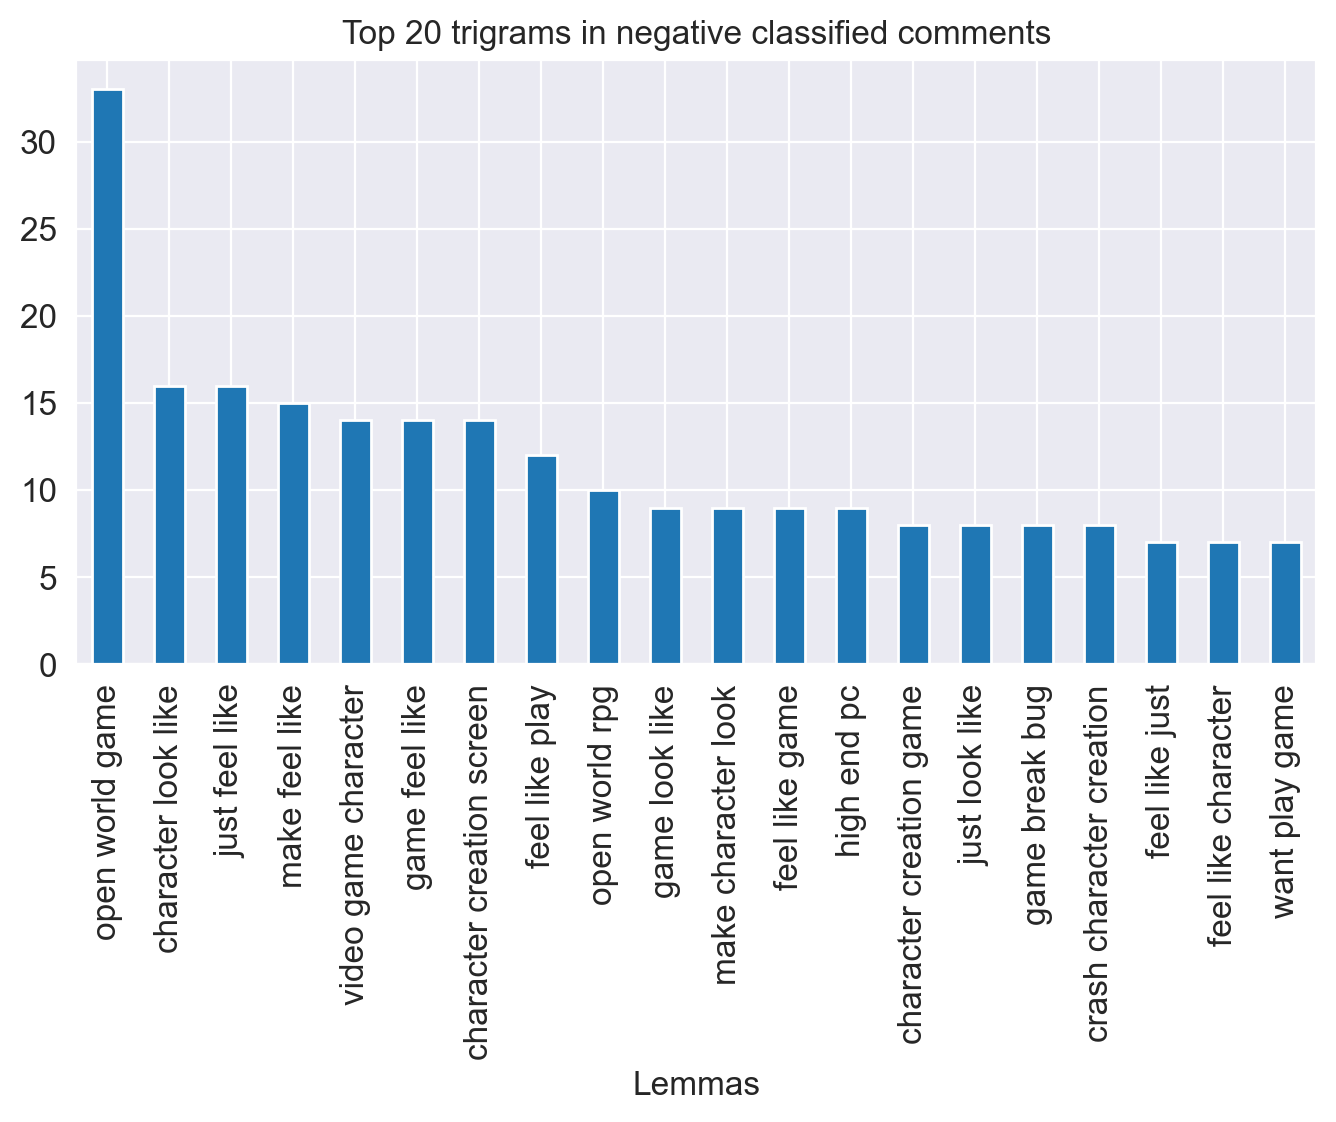

In [35]:
trigram_call("character")

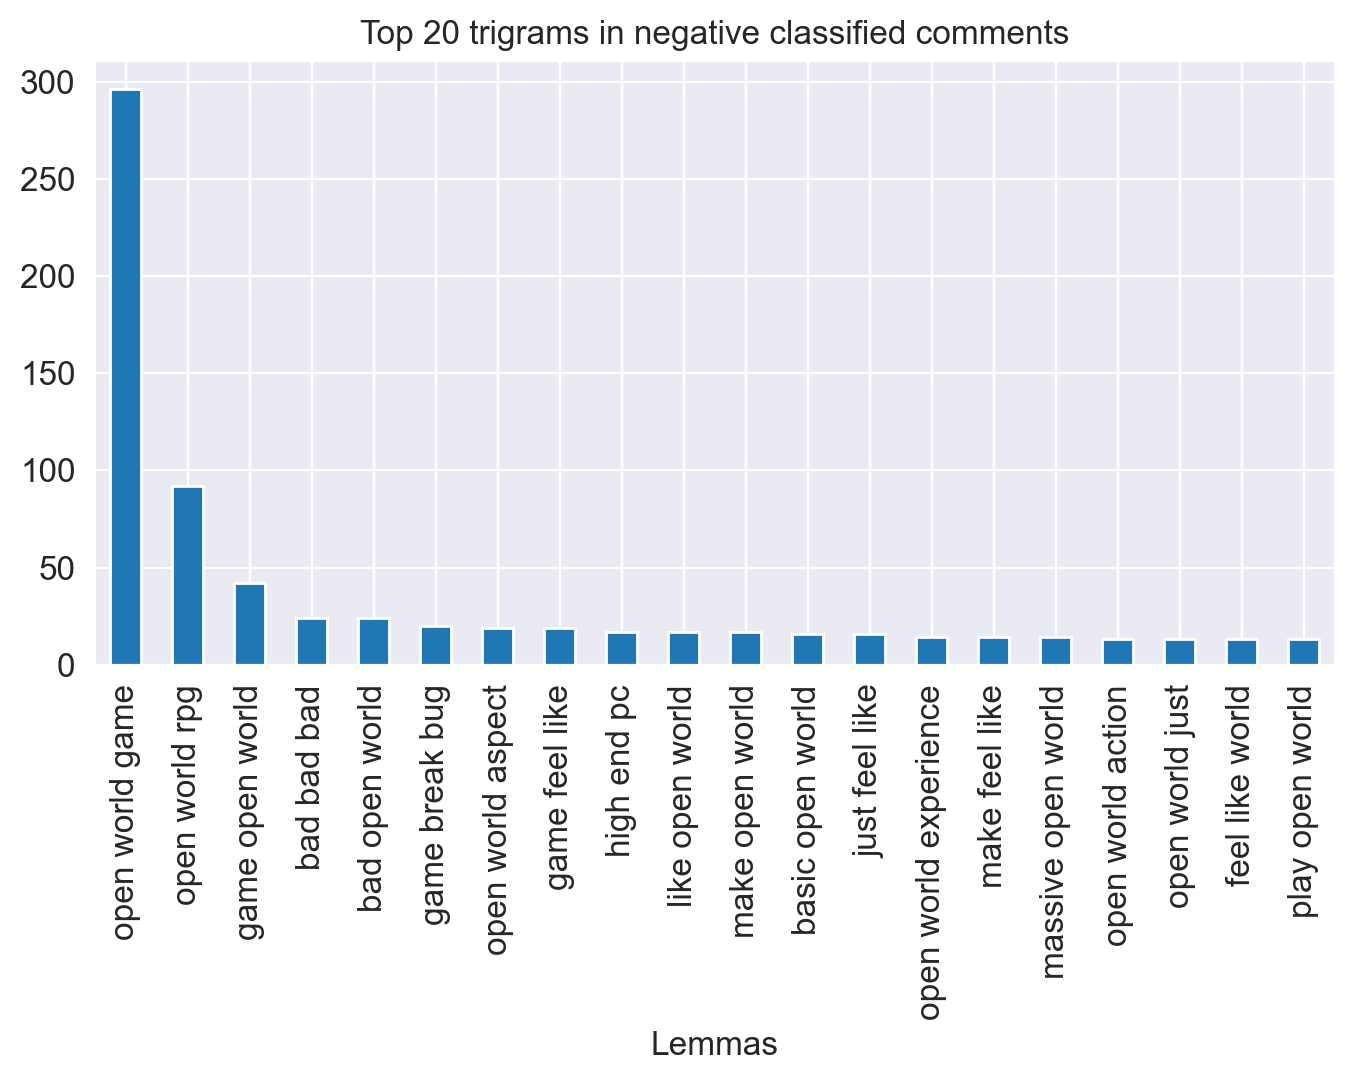

In [36]:
trigram_call("world")

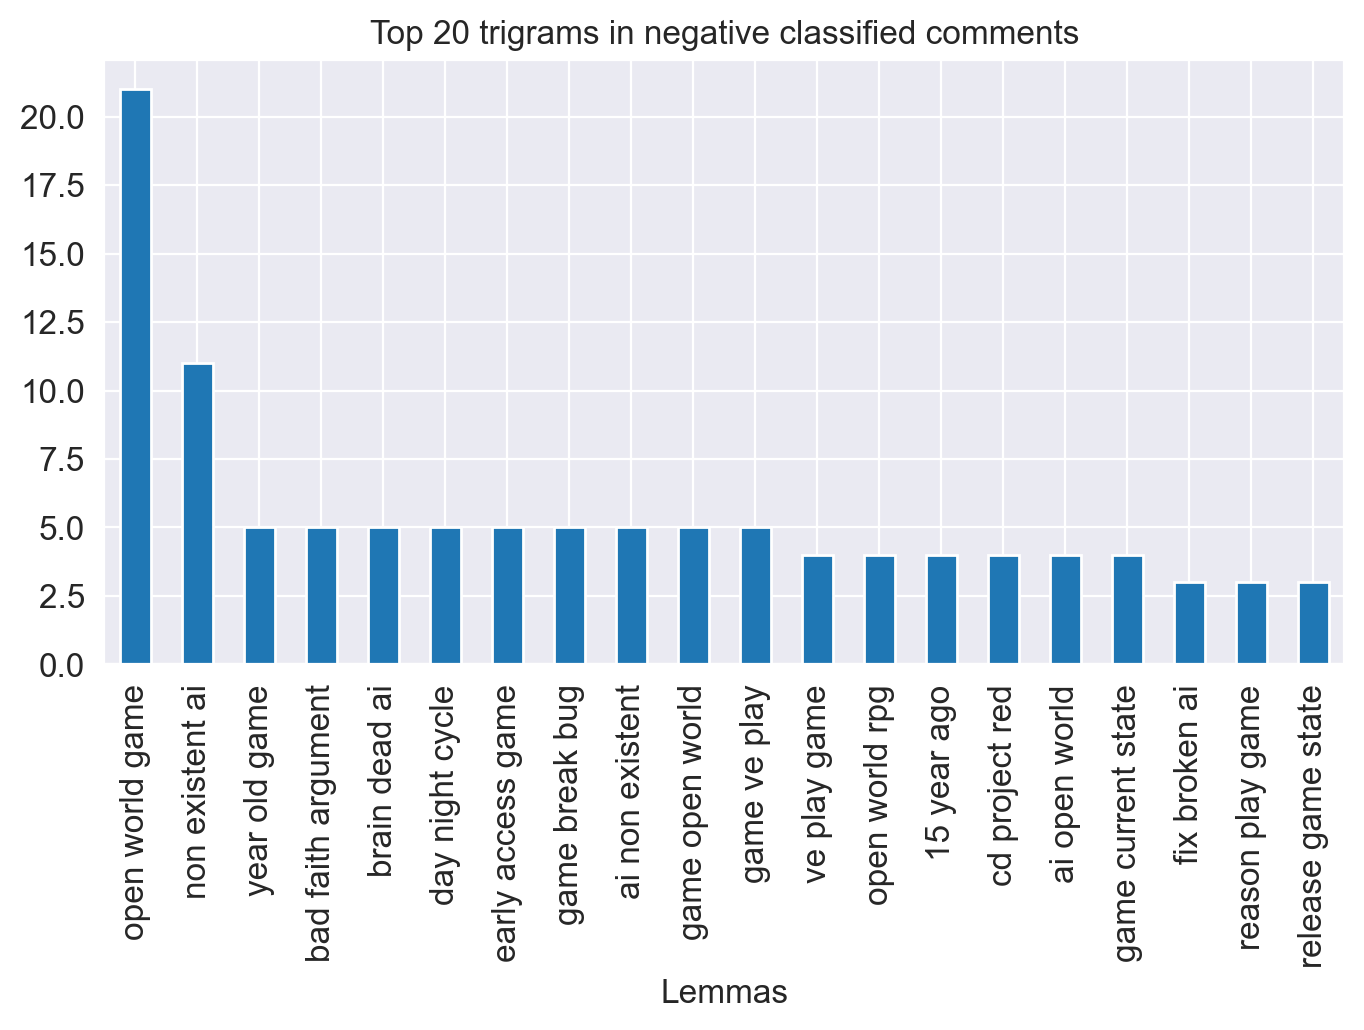

In [37]:
trigram_call("ai")

Durch diese Trigramm haben wir einen besseren Kontext über die jeweiligen Wörter bekommen. Die Trigramme mit der besten Aussagekraft sind: "character creation screen", "bad open world", "non existen ai" und "brain dead ai".
<hr>
Wir wollen uns zuletzt noch Samples ausgeben lassen, in denen diese Trigramme benutzt werden. Damit bekommen wir einen noch besseren Einblick in den Zusammenhang, in dem diese Trigramme stehen.
Wir definieren uns dafür eine "Keywords in Context"-Funktion.

In [40]:
from textacy.text_utils import KWIC
def kwic(doc_series, keyword, window=130, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window, print_only=False))
    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

Aufruf der Funktion mit "character creation screen":

In [41]:
kwic(df['lemmas'], ' character creation screen ', print_samples=5)

  0%|          | 0/85074 [00:00<?, ?it/s]

5 random samples out of 13 contexts for ' character creation screen ':
when first see   character creation screen   on PS5 think on monitor be break be how bad look holy crap be just sad
yeah lighting in   character creation screen   be ridiculous like be sure CDPR be think with decision be impossible make informed decision about color choice when have strong co
 be too high no be mad do get game be advertise action do ripple through game world bullet do even ripple through water also final   character creation screen   be like be advertise
hype game up to unreachable height true but game fail deliver in most basic aspect 'd expect from rpg ca customize character after   character creation screen   and be in CYBERPUNK game where style be supposedly CDPR even make big deal out of three major style and how people would react to 
have be able get past   character creation screen   without crash have update driver have restart try about 20 time give up


Wir sehen, dass der "character creation screen", welcher eine Stelle am Start des Spiels darstellt, oft Abstürze des Spiels zu Folge hatte.
<hr>
Aufruf der Funktion mit "bad open world": 

In [42]:
kwic(df['lemmas'], ' bad open world ', print_samples=5)

  0%|          | 0/85074 [00:00<?, ?it/s]

5 random samples out of 17 contexts for ' bad open world ':
on drive thru open world yea do ’ probably one stand out   bad open world   be pointless seem like focus on gameplay level design and quest Said open world be damn open world be pointless for but drive and 
just feel like main quest and open world aspect of game be two completely different thing sadly be actually one of   bad open world   game think 've ever play in term of game mechanic and interaction for so many reason but on other side main quest and side mission
yes fucking be try paint say ’   bad open world   game ’ ever play as bad game ’ ever play in general unless fucking game in existence be open world to then statement could never t
f investment in just feel like main quest and open world aspect of game be two completely different thing sadly be actually one of   bad open world   game think 've ever play in term of game mechanic and interaction for so many reason but on other side main quest and side mission
hi bur

Das Trigramm "bad open world" ist an sich schon aussagekräftig genug. Was man zusätzlich herauslesen kann, ist dass die Interaktionen und die Spielmechaniken die Gründe sind, dass die Open World als schlecht bezeichnet wird.
<hr>
Aufruf der Funktion mit "non existent ai" und "brain dead ai":

In [43]:
kwic(df['lemmas'], ' non existent ai ', print_samples=5)
kwic(df['lemmas'], ' brain dead ai ', print_samples=5)

  0%|          | 0/85074 [00:00<?, ?it/s]

5 random samples out of 13 contexts for ' non existent ai ':
say   non existent AI   be lump together with bug and glitch break game make sense though
once apply to busy bustling world with dozen of entity around far beyond be in Novigrad Witcher 3 have awkward horse race mediocre   non existent ai   from npc etc sincere hope be that thing be change out for drastically different setup and tell need know about where priority be s
 character in story make sense will map game in video game history as terrible product be before even mention obtuse combat system   non existent ai   and placeholder physics system say can enjoy game despite issue game have fan one will simply have lot less than most even on pc
zero mention of last minute cut content and false marketing promise such as   non existent ai   waste lifepath and dead empty world game will spend entire year get fix true release be should be December 2021
trust ’ work just fine on pc sure game actually run there in most case with var

  0%|          | 0/85074 [00:00<?, ?it/s]

5 random samples out of 6 contexts for ' brain dead ai ':
too little too late joke of game be gon fix empty shallow city too be gon fix   brain dead AI   x200b CDPR be over rate trash
let down problem game have be that be lack promise content bug can get over bug but ca get over BROKEN want system   brain dead ai   of citizen LITERALLY missing ai of traffic car and so on just give game as whole and then repair
life path be flesh out nearly enough very half bake need more dev time be incomplete product Buggy   brain dead ai   poor optimization lack rp way alter v after intro dead open world etc CDPR rep take hit big time
system be unfinished like   brain dead ai   and god awful insta spawn police be bug ’re unfinished will be address in patch
est from first fucking public demo(from 2 year ago break know be seriously wrong just get bad from there with crash and t pose and   brain dead ai   and npc with one fucking line of dialogue in be suppose be live city fuck game hurry fuck up Sony


Auch diese beiden Trigramme sind von sich aus schon aussagekräftig. Wir können durch die Samples aber herauslesen, dass das Verhalten der Polizei-AI Probleme darstellt. Außerdem werden sowohl die Bewegungen/Animationen der AI, als auch die fehlende AI für den Straßenverkehr bemängelt.

##  Quellen ##
* https://github.com/cjhutto/vaderSentiment
* https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
* https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
* https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
* https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/
* https://huggingface.co/transformers/model_doc/roberta.html
* https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
* https://scikit-learn.org/stable/
* https://www.gameswirtschaft.de/marketing-pr/sony-entfernt-cyberpunk-2077-playstation-store-211220/